In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [2]:
class Node:
    '''
    Class defining a node.

    Parameters
    ----------
        state : int
            State of a node (0 - susceptible, 1 - infected, 2 - recovered).
        index : int
            Index of a node.
            
    '''
    states = {'susceptible': 0, 'infected': 1, 'recovered': 2}
    
    def __init__(self, state, index):
        self.state = state
        self.index = index
        
    def get_state(self):
        return {v: k for k, v in self.states.items()}[self.state]
    
    def change_state(self, state):
        self.state = self.states[state]
    
    def __repr__(self):
        return repr(self.index) + ": " + repr({v: k for k, v in self.states.items()}[self.state])



class Graph:
    '''
    Class defining a graph.

    Parameters
    ----------
        links : array_like
            List of connections between nodes.
        susceptible : list
            List of susceptible changes.
        infected : list
            List of infected changes.
        recovered : list
            List of recovered changes.
        total_susceptible : list
            Cumsum of susceptible.
        total_infected : list
            Cumsum of infected.
        total_recovered : list
            Cumsum of recovered.
            
    '''
    def __init__(self, links):
        self.links = links
        self.susceptible, self.infected, self.recovered = [], [], []
                    
    def __repr__(self):
        return repr(self.links)
    
    def infect(self, model = 'SI', iterations = 20, si_p = 0.01, ir_p = 0.01,
               is_p = 0.01, rs_p = 0.01, reset = True, random_state = None):
        '''
        Selects random node as patient zero and performs the infection process among all nodes. 
        
        Parameters
        ----------
        model : string
            Model of infection (SI, SIS, SIR, SIRS).
        iterations : int
            Number of iterations.
        si_p : float
            Susceptible -> infected change probability. Must be between 0 and 1.
        ir_p : float
            Infected -> recovered change probability. Must be between 0 and 1.
        is_p : float
            Infected -> susceptible change probability. Must be between 0 and 1.
        rs_p : float
            Recovered -> susceptible change probability. Must be between 0 and 1.
        reset : boolean, optional
            Indicates, if all nodes should be set back to susceptible.
        random_state : int, optional
            Random state of the generator.

        Returns
        -------
        infect : Graph
            A Graph with infected nodes.

        '''
        random = np.random.RandomState(random_state)
        
        if reset == True:
            for node in self.links:
                node[0].state = Node.states['susceptible']
            self.susceptible.clear()
            self.infected.clear()
            self.recovered.clear()
        
        if model == 'SI':
            ir_p = 0
            is_p = 0
            rs_p = 0
        elif model == 'SIS':
            ir_p = 0
            rs_p = 0
        elif model == 'SIR':
            is_p = 0
            rs_p = 0
        elif model == 'SIRS':
            is_p = 0
        else:
            raise Exception('Model is not defined')
        
        self.si_p = si_p
        self.ir_p = ir_p
        self.is_p = is_p
        self.rs_p = rs_p
        
        patient_zero = random.randint(0, len(self.links))
        self.links[patient_zero][0].state = Node.states['infected']
        infected_sync, susceptible_sync, recovered_sync = [], [], []
        for i in range(iterations):
            sus, inf, rec = 0, 0, 0            
            for node in self.links:
                if node[0].get_state() == 'infected':
                    for neighboor in node:
                        if neighboor != node[0] and \
                            neighboor.get_state() == 'susceptible' and \
                            neighboor not in infected_sync and \
                            random.random_sample() < self.si_p:
                            infected_sync.append(neighboor)
                            
                if node[0].get_state() == 'recovered':
                    if random.random_sample() < self.rs_p:
                        susceptible_sync.append(node[0])
                        
                if node[0].get_state() == 'infected':
                    if random.random_sample() < self.ir_p:
                        recovered_sync.append(node[0])
                    if random.random_sample() < self.is_p:
                        susceptible_sync.append(node[0])
                
            for node in infected_sync:
                node.change_state('infected')
                inf += 1
                sus -= 1
            for node in susceptible_sync:
                if node.get_state() == 'infected':
                    inf -= 1
                elif node.get_state() == 'recovered':
                    rec -= 1
                sus += 1
                node.change_state('susceptible')
            for node in recovered_sync:
                node.change_state('recovered')
                rec += 1
                inf -= 1
                
            infected_sync.clear()
            susceptible_sync.clear()
            recovered_sync.clear()
            self.susceptible.append(sus)
            self.infected.append(inf)
            self.recovered.append(rec)
            
            self.total_infected = np.cumsum(self.infected)
            self.total_recovered = np.cumsum(self.recovered)
            self.total_susceptible = len(self.links) + np.cumsum(self.susceptible)

class NetworkGenerator():
    '''
    Class defining a network generator.
    
    '''
    def erdos_renyi(self, n: int = 1000, p: float = 0.02, random_state: int = None) -> Graph:
        '''
        Creates a network using erdos-renyi algorithm.
        
        Parameters
        ----------
        n : int
            Number of nodes.
        p : float
            Probability of connecting two nodes. Must be between 0 and 1.
        random_state : int, optional
            Random state of the generator.

        Returns
        -------
        erdos_renyi : Graph
            A Graph with created links.
            
        '''
        if p < 0 or p > 1:
            raise Exception("Probability cannot be greater than 1 or lower than 0.")
        random = np.random.RandomState(random_state)
        links = [[Node(Node.states['susceptible'], i)] for i in range(n)]
        for a in links:
            for b in links:
                if (a != b) and (a[0] not in b):
                    if random.random_sample() < p:
                        a.append(b[0])
                        b.append(a[0])
        return Graph(np.array(links))
    
    def watts_strogatz(self, n: int = 1000, rank: int = 20, p: float = 0.1, random_state=None) -> Graph:
        '''
        Creates a network using erdos-renyi algorithm.
        
        Parameters
        ----------
        n : int
            Number of nodes.
        rank : int
            Rank of each node. Must be even.
        p : float
            Probability of rewiring two nodes. Must be between 0 and 1.
        random_state : int, optional
            Random state of the generator.

        Returns
        -------
        watts_strogatz : Graph
            A Graph with created links.

        '''
        if p < 0 or p > 1:
            raise Exception("Probability cannot be greater than 1 and lower than 0.")
        if rank % 2 != 0:
            raise Exception('Rank should be even.')
        random = np.random.RandomState(random_state)
        links = [[Node(Node.states['susceptible'], i)] for i in range(n)]
        for i, a in enumerate(links):
            for j in range(i + 1, i + rank // 2):
                if j >= n:
                    j -= n
                a.append(links[j][0])
                links[j].append(a[0])
                if random.random_sample() < p:
                    a.remove(links[j][0])
                    links[j].remove(a[0])
                    while True:
                        random_node = random.randint(0, len(links))
                        if random_node != i and random_node != i + 1 and random_node != i - 1:
                            break
                    a.append(links[random_node][0])
                    links[random_node].append(a[0])
        return Graph(np.array(links))
    
    def barabasi_albert(self, n: int = 100, m: int = 10, random_state: int = None) -> Graph:
        '''
        Creates a network using barabasi-albert algorithm.
        
        Parameters
        ----------
        n : int
            Number of nodes.
        m : int
            Number of edges to attach from a new node to existing nodes.
        random_state : int, optional
            Random state of the generator.

        Returns
        -------
        barabasi_albert : Graph
            A Graph with created links.

        '''
        
        links = [[Node(Node.states['susceptible'], i)] for i in range(n)]
        random = np.random.RandomState(random_state)
        for i, a in enumerate(links[:(m + 1)]):
            for j in range(i + 1, m + 1):
                a.append(links[j][0])
                links[j].append(a[0])
        
        count = 0
        for i in range(m + 1, n): 
            id_lst = []
            for j in range(m + 1 + count):
                for k in range(len(links[j])):
                    id_lst.append(j) 
            for j in range(m):
                random_node = random.randint(0, len(id_lst))
                id = id_lst[random_node]
                links[i].append(links[id][0])
                links[id].append(links[i][0])
                id_lst = [x for x in id_lst if x != id]
            count += 1       
         
        return Graph(np.array(links))

In [5]:
ng = NetworkGenerator()
er = ng.erdos_renyi(n=1000)
ws = ng.watts_strogatz(n=1000)
ba = ng.barabasi_albert(n=1000)

In [12]:
si_list = np.arange(0, 0.5, 0.01)
infected_er = []
infected_ws = []
infected_ba = []

for si in si_list:
    er.infect(model = 'SIR', iterations = 100, si_p=si, ir_p=0.1)
    ws.infect(model = 'SIR', iterations = 100, si_p=si, ir_p=0.1)
    ba.infect(model = 'SIR', iterations = 100, si_p=si, ir_p=0.1)
    infected_er.append(er.total_infected.mean())
    infected_ws.append(ws.total_infected.mean())
    infected_ba.append(ba.total_infected.mean())

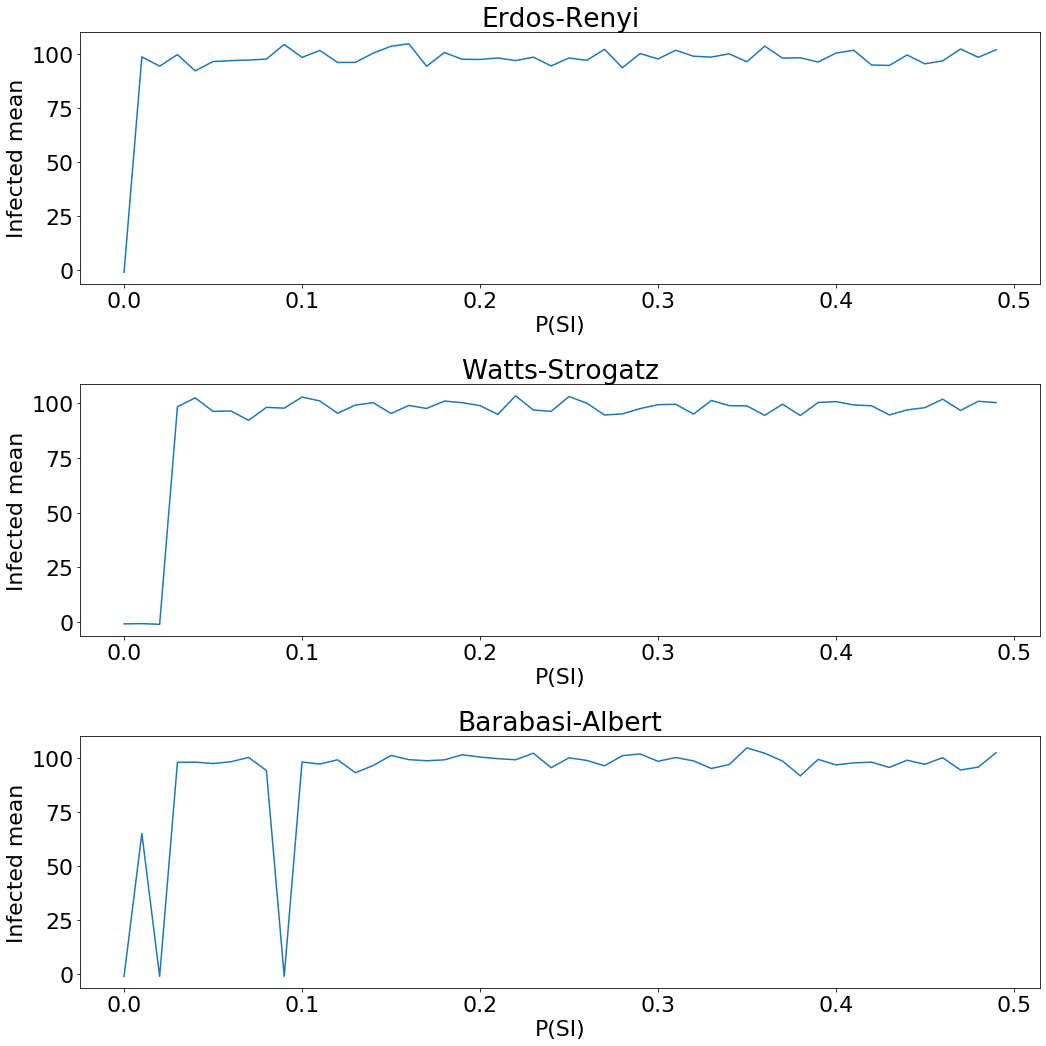

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(15,15))
# erdos-renyi
ax[0].plot(si_list, infected_er)
ax[0].set_xlabel('P(SI)')
ax[0].set_ylabel('Infected mean')
ax[0].set_title('Erdos-Renyi')
# watts-strogatz
ax[1].plot(si_list, infected_ws)
ax[1].set_xlabel('P(SI)')
ax[1].set_ylabel('Infected mean')
ax[1].set_title('Watts-Strogatz')
# barabasi-albert
ax[2].plot(si_list, infected_ba)
ax[2].set_xlabel('P(SI)')
ax[2].set_ylabel('Infected mean')
ax[2].set_title('Barabasi-Albert')

fig.tight_layout()
plt.show()

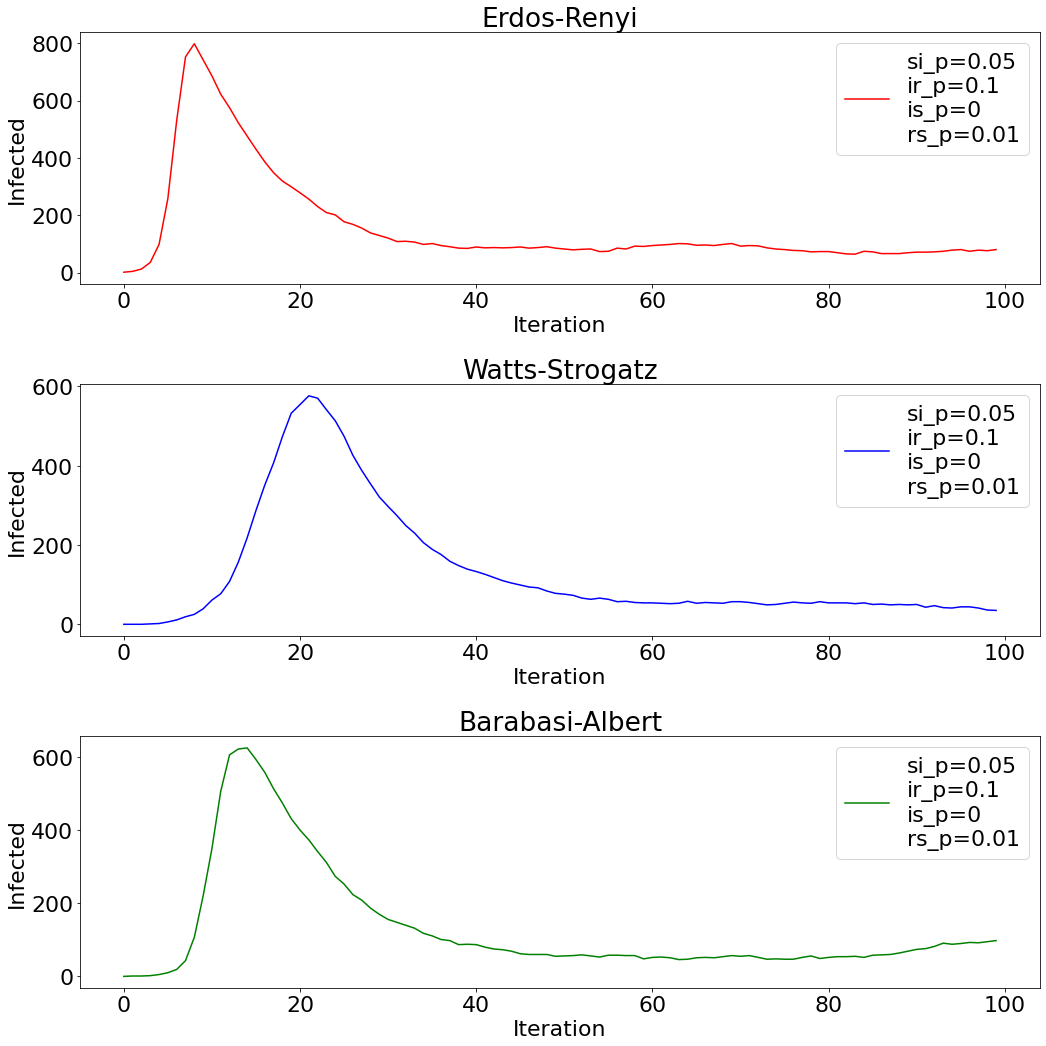

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(15,15))

#erdos-renyi
x, y = range(0, len(er.infected)), [case for case in er.total_infected]
ax[0].plot(x, y, color = 'red', label='si_p={}\nir_p={}\nis_p={}\nrs_p={}'.format(er.si_p, er.ir_p, er.is_p, er.rs_p))
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Infected')
ax[0].set_title('Erdos-Renyi')
ax[0].legend()


#watts-strogatz
x, y = range(0, len(ws.infected)), [case for case in ws.total_infected]
ax[1].plot(x, y, color = 'blue', label='si_p={}\nir_p={}\nis_p={}\nrs_p={}'.format(ws.si_p, ws.ir_p, ws.is_p, ws.rs_p))
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Infected')
ax[1].set_title('Watts-Strogatz')
ax[1].legend()

#barabasi-albert
x, y = range(0, len(ba.infected)), [case for case in ba.total_infected]
ax[2].plot(x, y, color = 'green', label='si_p={}\nir_p={}\nis_p={}\nrs_p={}'.format(ba.si_p, ba.ir_p, ba.is_p, ba.rs_p))
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Infected')
ax[2].set_title('Barabasi-Albert')
ax[2].legend()


fig.tight_layout()
plt.show()